In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style("ticks")
sns.set_context("talk")

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Image

from helpers import plotting
from helpers.perceptron import Perceptron

# 1. The Iris dataset

The iris dataset contains three classes with 50 instances per class; Each class refers to a type of iris plant (setosa, versicolor, and virginica).

For each instance, the width and length of the petal and sepal is given (two leaf-like parts enclosing the bud; see image below).

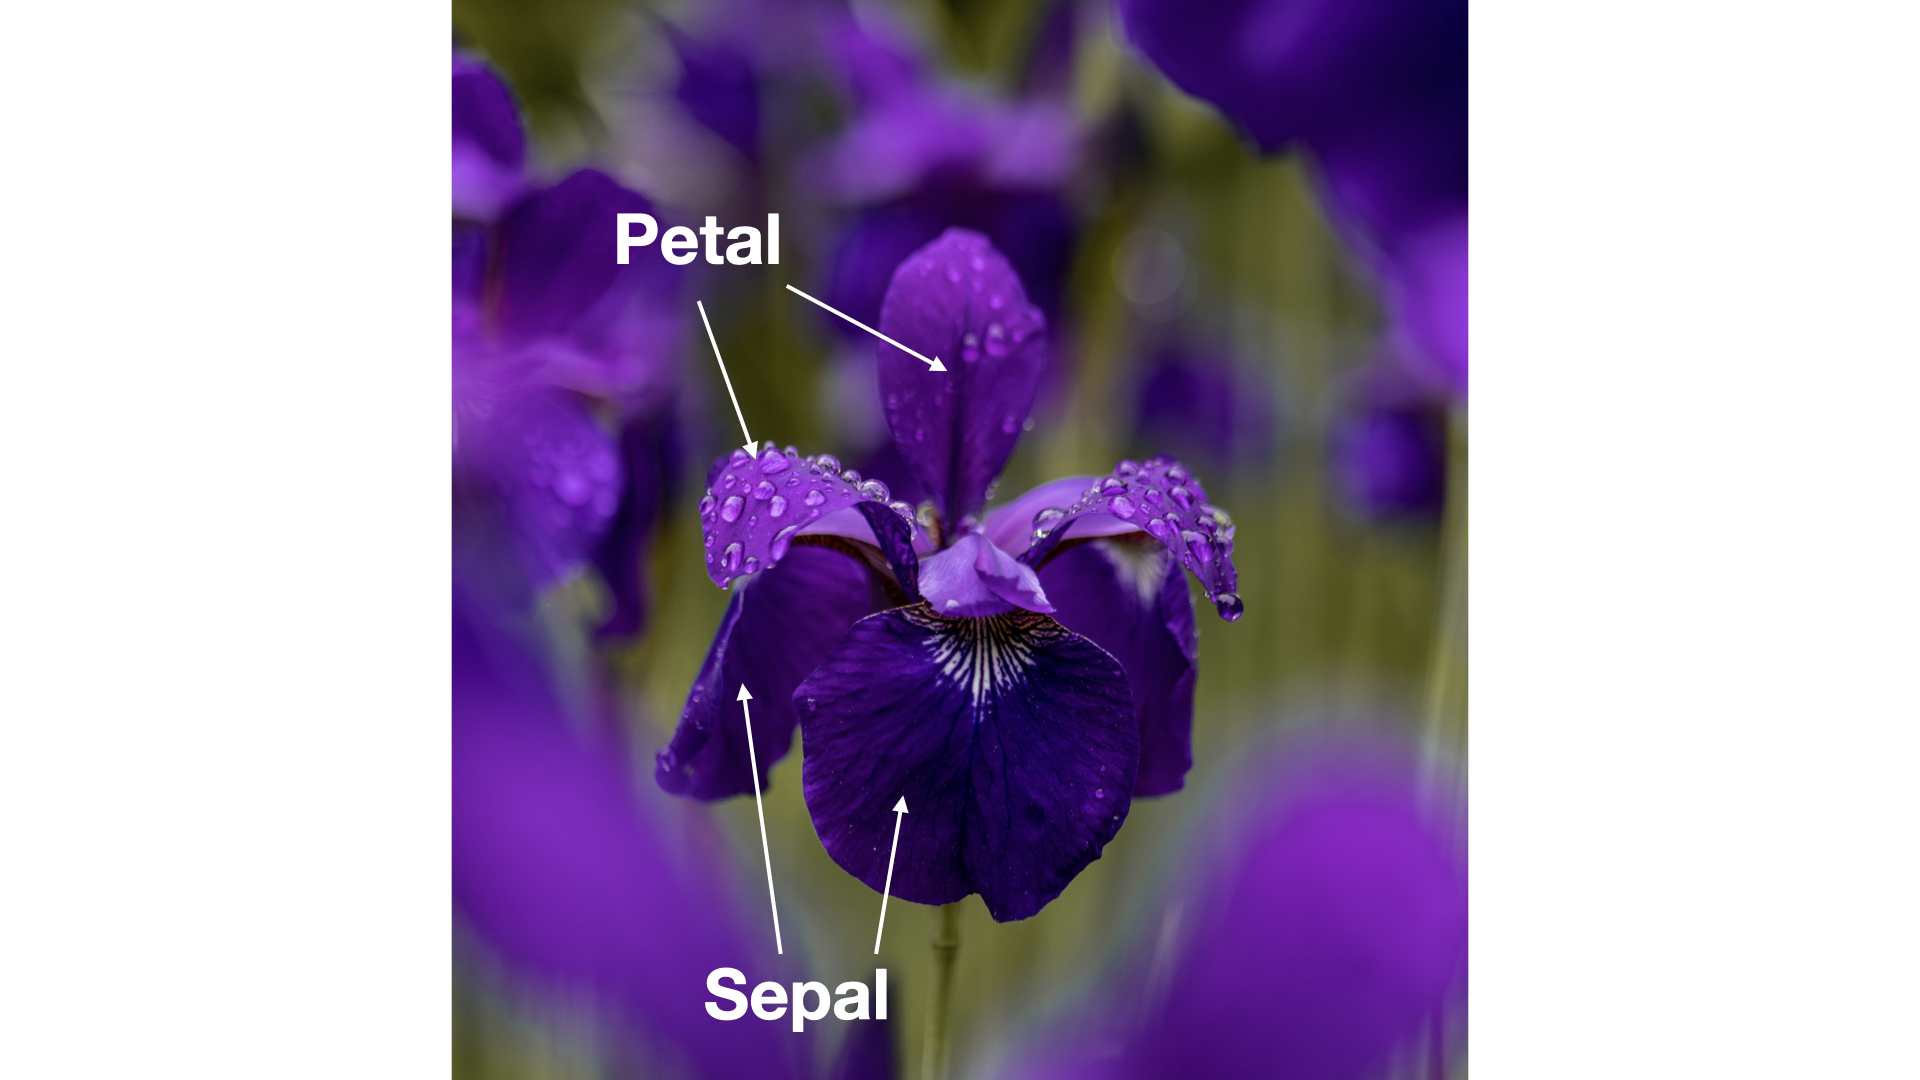

In [2]:
Image(filename='materials/images/Iris_data.png')

*Image adapted from: https://www.pexels.com/search/iris%20flower/*

We can load the data directly from the [scikit-learn](https://scikit-learn.org/stable/) library:

In [3]:
from sklearn.datasets import load_iris
data = load_iris()

`data` is a dictionary with the following keys (or entries): 

In [4]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

The iris type is encoded in the `target` entry:

In [5]:
np.unique(data['target'])

array([0, 1, 2])

The corresponding name of each iris type can be found in `target_names`:

In [6]:
data['target_names']

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

The length and width of the sepal and petal of each instance are given in the `data` entry:

In [7]:
# for better visibility, we display the data in a dataframe
pd.DataFrame(data=data['data'], columns=data['feature_names']).head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


In [8]:
data['data'].shape

(150, 4)

Let's take a closer look at the data, and plot the instances according to the sepal (left) and petal (right) width and length:

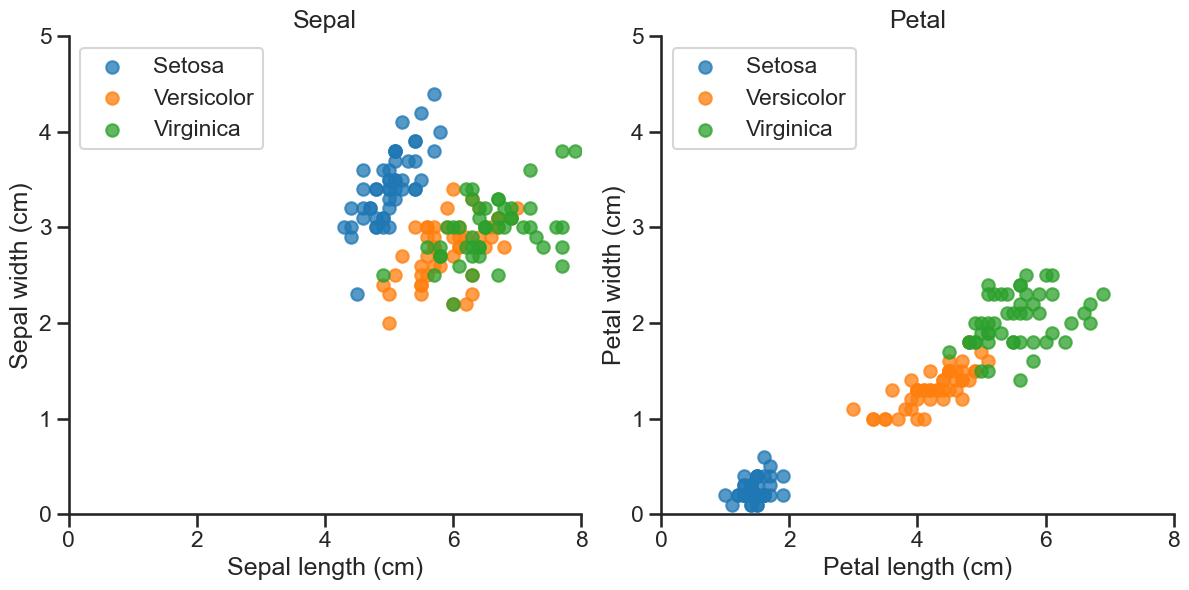

In [9]:
fig, axs = plotting.plot_iris_dataset(data)
fig.savefig('figures/Figure-1_Iris-Data.png', dpi=300)

## 1.2 Simplifying to two classes

For simplicity, we will only focus on setosa and versicolor irises and try to distinguish them by their petal width and length (blue and orange in the right panel).

To do this, we will first subset our data to the classes 0 and 1 (setosa and versicolor) as well as the feature columns 2 and 3 (petal length and width):

In [10]:
idx = np.isin(data['target'], (0, 1)) # get row index where target is either 0 or 1
X = data['data'][idx,2:4] # subset data
y = data['target'][idx] # subset labels

Our data subset now contains 100 instances (50 for each of the two iris types) and 2 features per instance:

In [11]:
X.shape

(100, 2)

Looking at the data, distinguishing the two iris types should be easy (as we could simply draw a line between the yellow and blue dots):

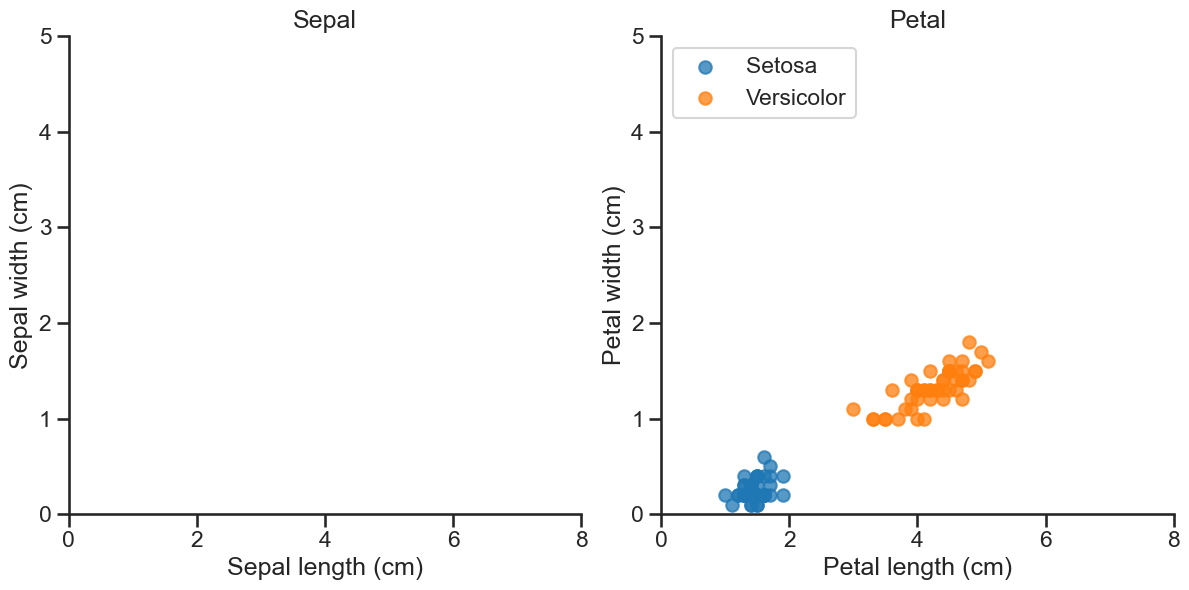

In [12]:
fig, axs = plotting.plot_iris_dataset(data, classes=[0,1], features=['petal'])
fig.savefig('figures/Figure-2_Two-Class-Iris-Data.png', dpi=300)

*Now, how do we train a classifier to separate both iris types?*

# 2. The Perceptron algorithm

## 2.1 Inspired by biological neurons

The Perceptron algorithm is loosely inspired by biological neurons.

A biological neuron receives signals of variable magnitude through its dendrites. These input signals are accumulated in the cell body; once the accumulated signal exceeds a certain threshold, the neuron outputs a signal through its axon:

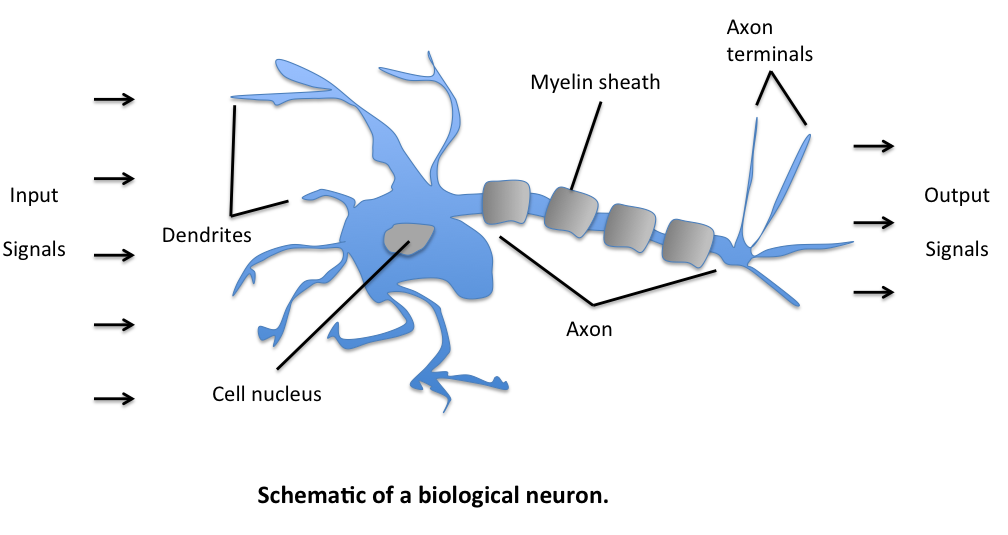

In [13]:
Image(filename='materials/images/Perceptron_neuron.png')

*source: https://sebastianraschka.com/Articles/2015_singlelayer_neurons.html*

## 2.2 The algorihm

The Perceptron algorithm implements these basic biological processing steps as follows:

1. It receives an input signal for each feature $x_i$ of a data instance (in our example, the length and width of the petal).


2. These input signals are then scaled through a set of weights $w$ (one for each feature $x_i$ of the input) and summed (mimicking the "cell body" of the neuron; note that we here also add a constant $b$ to the sum (*the bias*)): $Z = \sum_i w_ix_i + b$


3. Lastly, the weighted sum $Z$ is outputed and scaled with an activation function $\phi(\cdot)$.

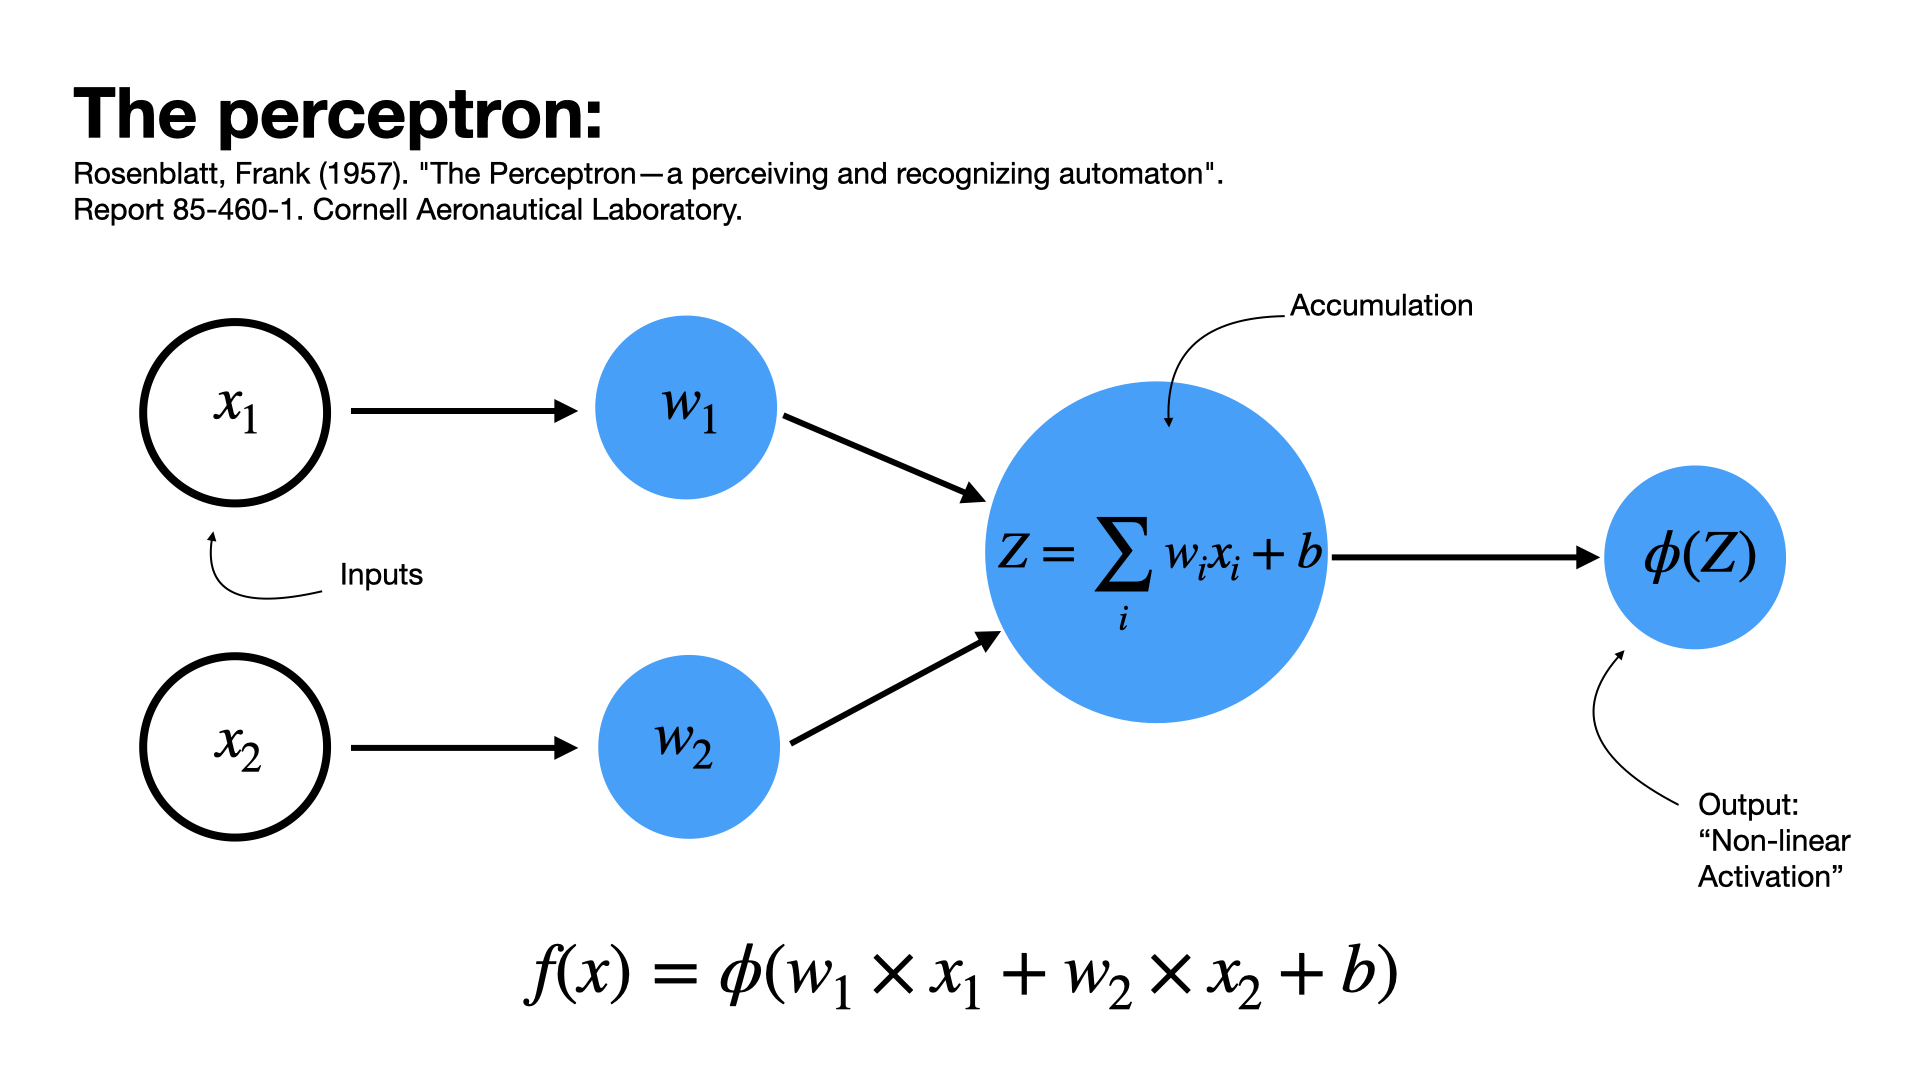

In [14]:
Image(filename='materials/images/Perceptron.jpeg')

### The activation function $\phi(\cdot)$:

The classical Percpetron algorithm uses a step [activation function](https://en.wikipedia.org/wiki/Activation_function) that outputs a value of 1 if the weighted sum is bigger than 0 and -1 otherwise.

Here, we will be using the sigmoid activation function instead. The sigmoid scales its input to a value between 0 and 1. It can thereby be used to estimate a probability that each data instance belongs to class 1 (i.e., versicolor irises).

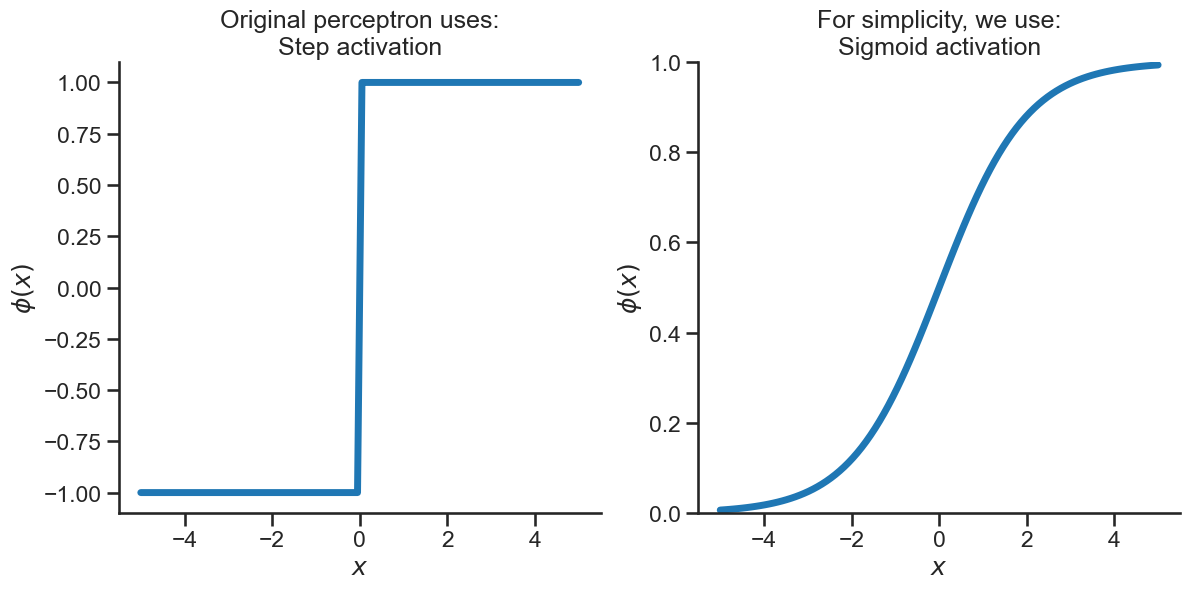

In [15]:
fig, axs = plotting.plot_activation_functions()
fig.savefig('figures/Figure-3_Perceptron-Activations.png', dpi=300)

# 3. Loss functions

Now that we have decided on an architecture for our classifcation algorithm, how do we determine the specific parameters for the weights $w$ that allow us to best distinguish between the two iris types?

To do this, we need to define a loss function.

Conceptually, a loss function $L$ indicates how good the predictions of the model are, given specific parameter weights and the data.

For our perceptron algorithm, we can use the binary [cross-entropy loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html):

$L = -(y \times log(p) + (1-y) \times log(1-p))$ 

As we can see, the cross-entropy loss consists of *two* components:
   - the first applies if $y = 1$ and
   - the other if $y = 0$

(in our example, $y$ is a binary variable that indicates the two iris types).

Let's look at these two parts of the loss in more detail: 

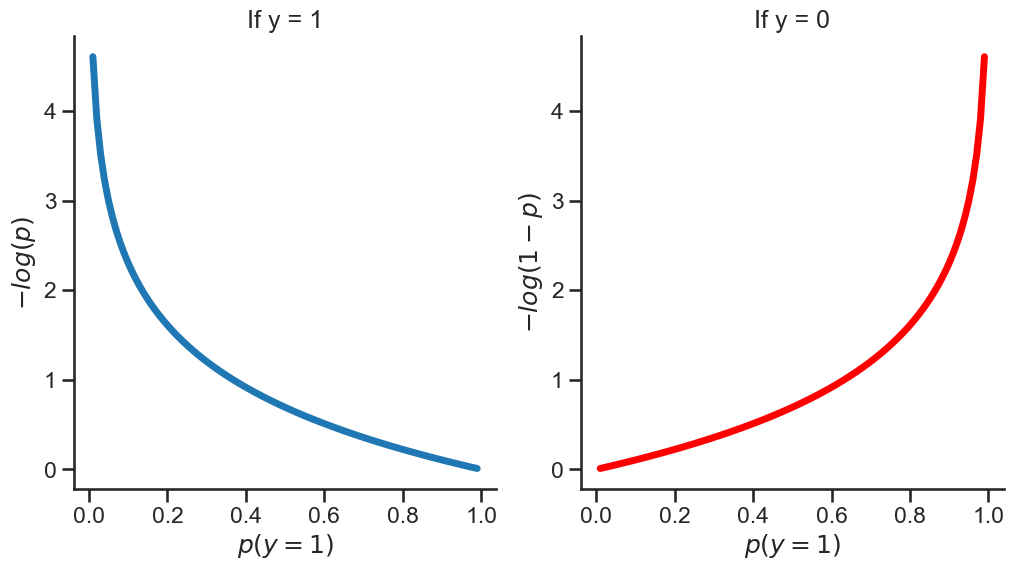

In [16]:
fig, axs = plotting.plot_cross_entropy_loss()
fig.savefig('figures/Figure-4_Cross-Entropy-Loss.png', dpi=300)

We can see that the first part of the loss ($-log(p)$; in blue) is minimal when the prediction $p(y=1)$ (i.e., $\phi(x)$) of our model is close to $1$.

Similarly, the second part of the loss ($-log(1-p)$; in red) is minimal when the prediction $p(y=1)$ of our model is close to $0$.

Hence, the full cross-entropy loss is minimal when our predicted probabilities are as close as possible to the actual target classes (here, 0 and 1). 

*Our goal is thus to find the set of weight parameters that minimize the cross-entropy loss.*

To make this more clear, we can take a closer look at how the loss function changes as a function of the two weights of our perceptron.

(For illustrative purposes, we fix the bias parameter $b$ in this analysis.)

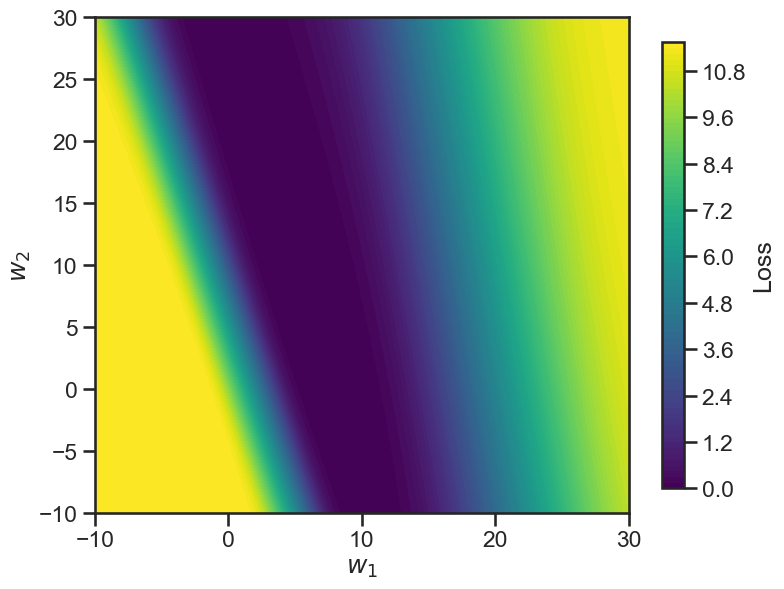

In [17]:
fig, ax = plotting.plot_perceptron_loss(X, y, dimensions='2d')
fig.savefig('figures/Figure-5_Our-Perceptron-Loss-Function-2D.png', dpi=300)

To get a better feeling for the slope (or steepness) of the loss, let's look at this in 3D:

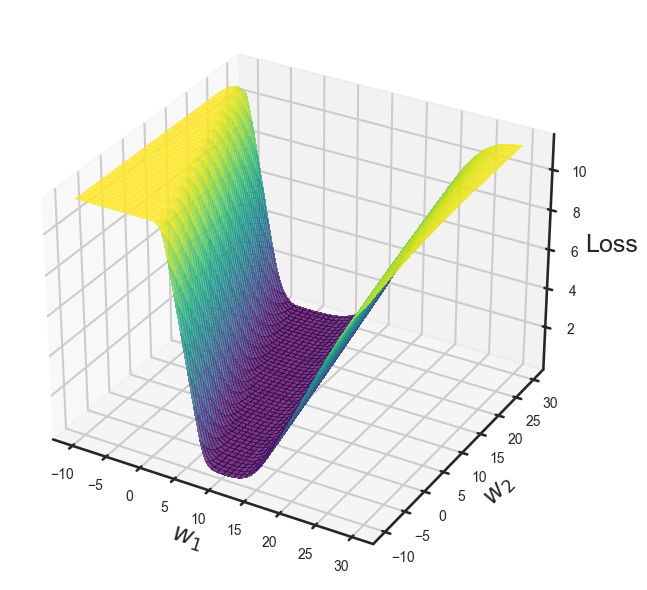

In [18]:
fig, ax = plotting.plot_perceptron_loss(X, y, dimensions='3d')
fig.savefig('figures/Figure-6_Our-Perceptron-Loss-Function-3D.png', dpi=600)

Ok! This is a pretty steep descent with a very clear valley; Finding a minimum should be easy!

# 4. Gradient descent

## 4.1 The Theory

[Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) is one of the most central techniques of modern machine learning. Its goal is to find a (local) minimum of a loss function, given an input dataset.

We have already seen that our loss function changes with the values of our two Perceptron weights $w$.

To find a minimum of the loss function, the gradient descent algorithm utilizes the partial derivative of the loss  w.r.t. to the parameter weights. For a specific parameter value, this derivative indicates whether the loss is increasing or decreasing (or not changing at all) when the parameter value is increased (see the illustration below).

To find the weights that minimize the loss function, gradient descent procedes as follows: 

1. First, it initializes the weights randomly (here, between -1 and 1).


2. Subsequently, it computes the partial derivative of the loss function with respect to the current weights (we denote this partial dericative by: $\frac{dL}{dw}$). This partial derivative indicates how much the loss function changes at its current value w.r.t. a change in $w$: 
    - A negative derivative indicates that the loss decreases with an increase in $w$
    - A positive derivative indicates that the loss increases with an increasing $w$. 


3. To move closer to the minimum of the loss, gradient descent simply subtracts the partial derivative from the current set of weights $w = w - \alpha \times \frac{dL}{dw}$. Note that the gradient descent algorithm also scales the derivative by $\alpha$ (*the learning rate*), allowing us to adjust the size of the step that the algorithm takes at each iteration.


4. By the use of this mechanism, the gradient descent algorithm procedes iteratively until it reaches a minimum of the loss function. Typically, we know that we have reached a minimum when the partial derivatives (and thereby the weights) do not change much anymore with an iteration.

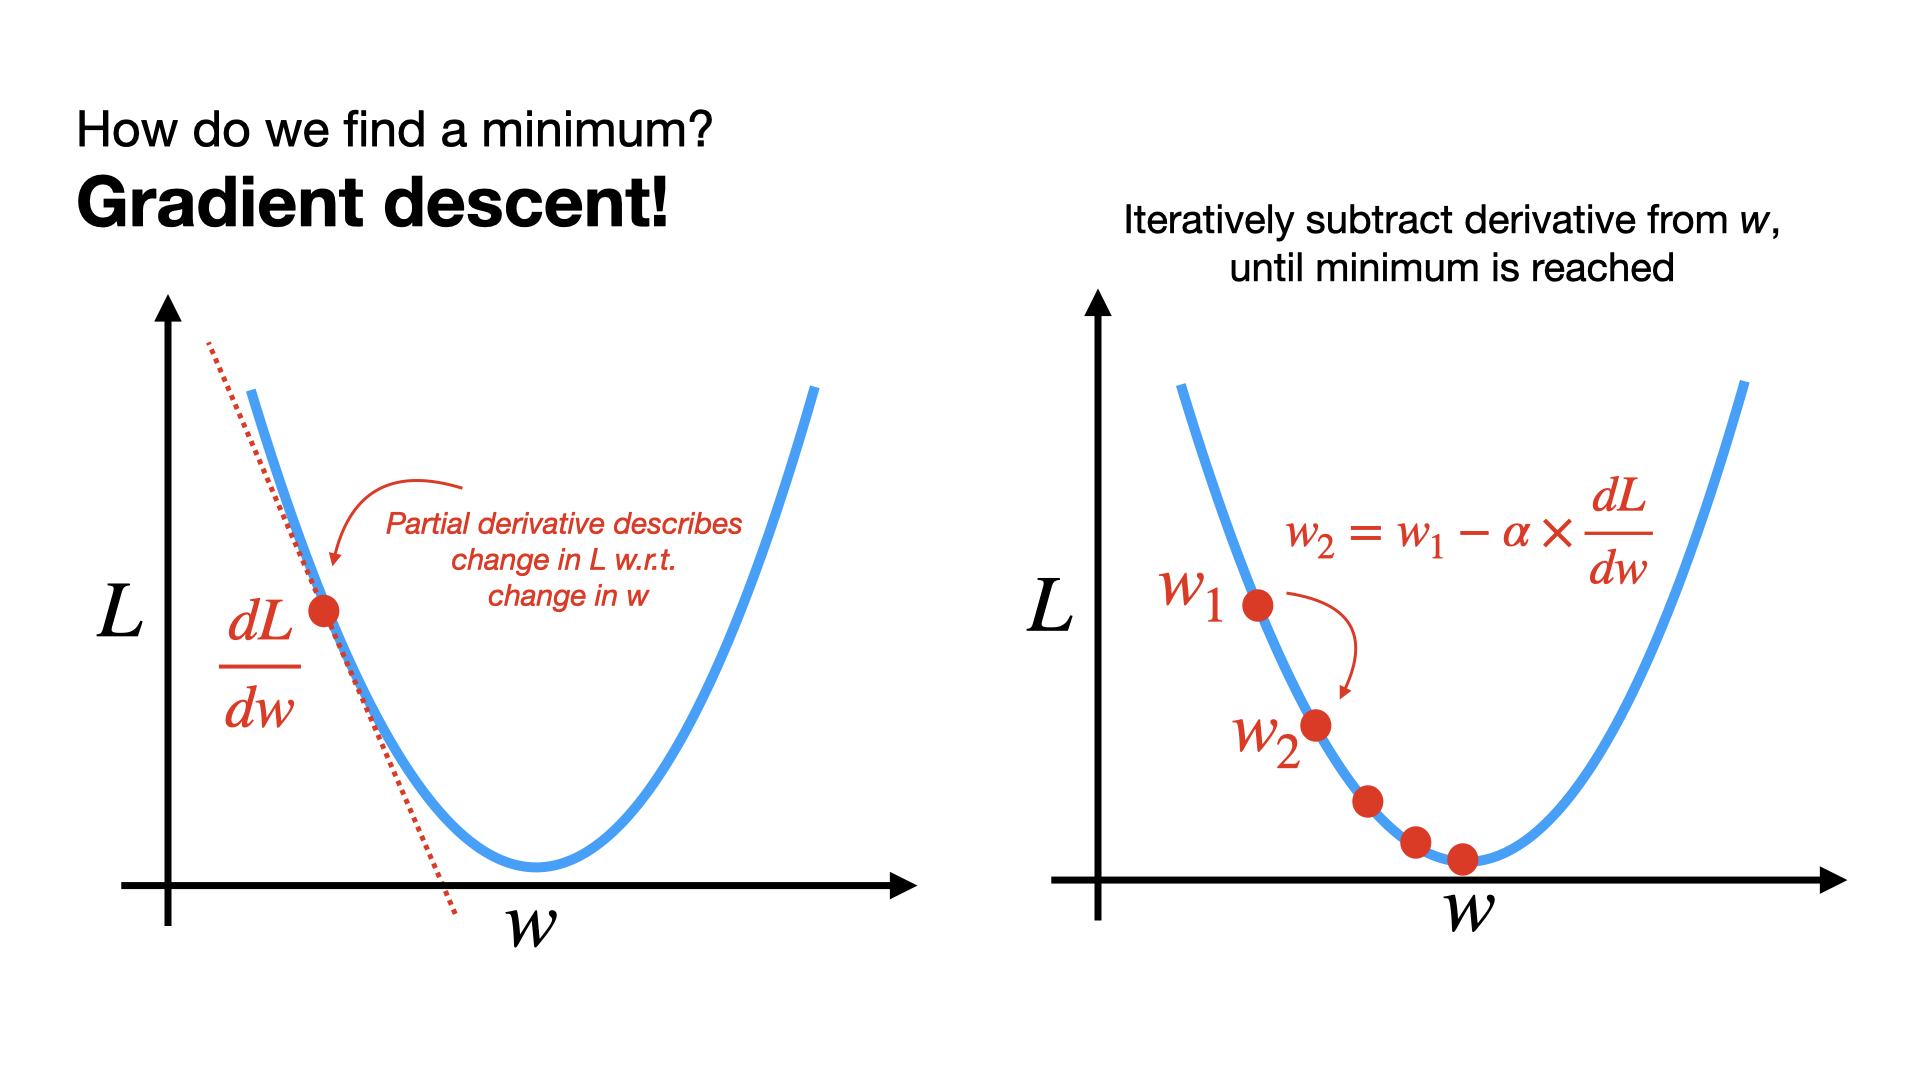

In [19]:
Image(filename='materials/images/Gradient-Descent.png')

### Stochastic Gradient Descent: 

Note that in practice, gradient descent often does not use the full dataset to update the model weights at each iteration, as the datasets are often too big; instead it draws a random sample at each iteration (where the number of instances in each draw is defined as the "batch size"). This procedure is called [*stochastic* gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).

## 4.2 Applying gradient descent to our algotihm

For simplicity, I have already written a simple perceptron implementation, which you can find in `helpers.perceptron`:

In [20]:
np.random.seed(4123) 
perceptron = Perceptron(
    n_in=2 # number of input features that our Perceptron expects 
)

To apply the gradient descent algorithm to our perceptron (with `perceptron.train`), we need to set all relevant hyper-parameters:

In [21]:
# running the training
np.random.seed(4123) 
perceptron.train(
    
    X=X, # the data (indicating the petal width and length of each instance)
    
    y=y, # data labels (iris types)
    
    n_steps=35000, # the number of gradient descent iterations (or steps) that we will perform
    
    batch_size=32, # the number of random samples that we draw at each iteration 
    
    learning_rate=0.1 # scaling of the step size (indicated as alpha in the image above)

) 
print('Your final loss is: {}'.format(perceptron.training_loss[-1]))

100%|██████████| 35000/35000 [00:02<00:00, 15008.95it/s]

Your final loss is: 0.0026093592022329443


Let's take a closer look at the training process, by plotting the gradient descent steps at different iterations of the algorithm (again by the use of a helper function from `helpers.plotting`):

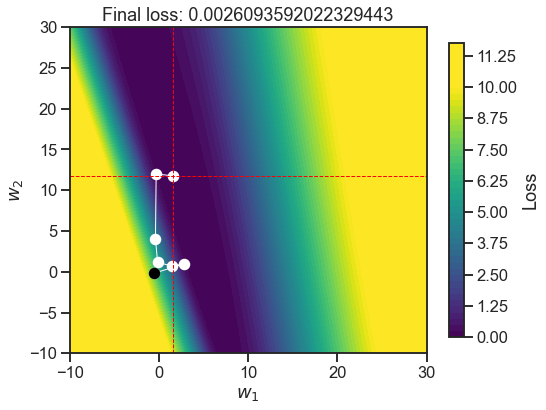

In [22]:
fig, ax = plotting.plot_gradient_descent_path(
    
    perceptron=perceptron, # our trained perceptron
    
    X=X, # the data
    
    y=y # data labels
)
fig.savefig('figures/Figure-7_Our-Perceptron-Gradinet-Descent-Path.png', dpi=300)

Now that we have obtained a parameter estimate (as marked by the red cross in the plot above), we can test whether our trained Perceptron accurately distinguishes between setosa and versicolor irises! 

To do this, we can plot its decision boundary:

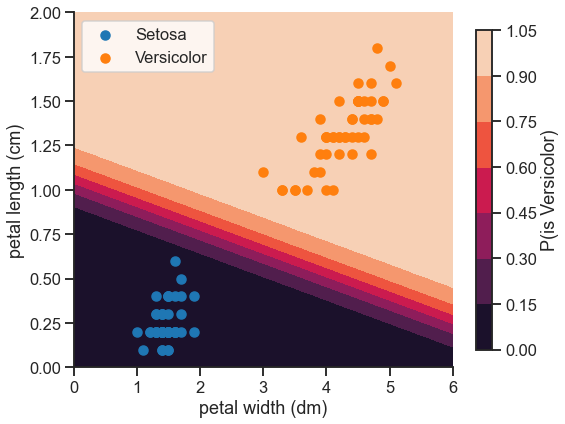

In [23]:
fig, ax = plotting.plot_perceptron_decision_boundary(
    
    perceptron=perceptron, # our trained perceptron
    
    X=X, # the data
    
    y=y, # data labels
    
    x1label='petal width (dm)', # name of feature 1 (x1)
    
    x2label='petal length (cm)', # name of feature 2 (x2)
    
    y_labels=['Setosa', 'Versicolor'] # names of classes (here, iris types)
)
fig.savefig('figures/Figure-8_Our-Perceptron-Decision-Function.png', dpi=300)

Yay! Our perceptron accurately distinguishes the two iris types.

As you can see, the decision boundary of the Perceptron represents a [hyperplane](https://en.wikipedia.org/wiki/Hyperplane); a subspace whose dimension is one less than that of the data; for two-dimensional data, the decision boundary thus represents a straight line.

# 5. Your exercise

To give you a more intuitive understanding of the interplay between the number of iterations, the batch size, and the learning rate of the gradient descent algorithm, play around with them in the code below. 

The code will output a figure of the loss surface, your gradient descent steps, and your final loss value.

**1. What would be a good learning rate and batch size for this problem?**

**2. What is the smallest finite loss value that you can achieve?**

100%|██████████| 4000/4000 [00:00<00:00, 14389.98it/s]


Your final loss is: 0.007748552672860285


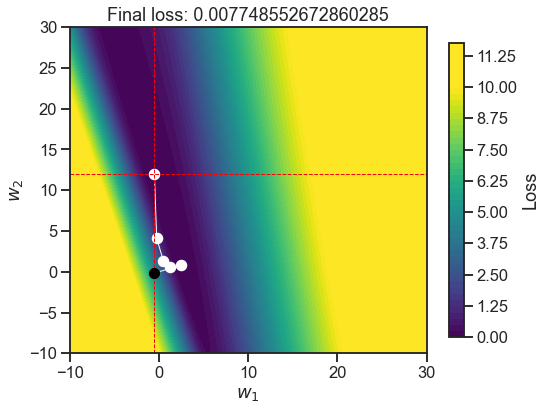

In [24]:
# set random seed
np.random.seed(4123)



# 1. create an instance of the perceptron
perceptron = Perceptron(n_in=2)



# 2. Indicate gradient descent parameters
# ***Your values go here:***
n_steps = 4000 # number of gradient descent steps
batch_size = 32 # number of random samples drawn at each iteration (needs to be < 101)
learning_rate = 0.1 # our learning rate



# 3. Perform gradient descent
perceptron.train(
    X=X, # the data
    
    y=y, # data labels
    
    n_steps=n_steps, # number gradient descent steps
    
    batch_size=batch_size, # number instances per iteration
    
    learning_rate=learning_rate
)
print('Your final loss is: {}'.format(perceptron.training_loss[-1]))



# 4. plot gradient descent path
fig, ax = plotting.plot_gradient_descent_path(
    perceptron=perceptron, # the trained perceptron
    X=X, # the data
    y=y # data labels
)